In [137]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from utils.utils import get_google_play_reviews

import os
from dotenv import load_dotenv

from utils.utils import TopicNeuralNet
pd.set_option('display.max_colwidth', None)

from collections import Counter
import seaborn as sns

## Import data

In [138]:
path = "./data/"

In [139]:
df = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

In [140]:
df["app"].unique()

array(['co.mona.android', 'com.bybit.app', 'com.binance.dev'],
      dtype=object)

In [141]:
binance_index = df["app"]== "com.binance.dev"
crypto_index = df["app"]== "co.mona.android"
bybit_index = df["app"]== 'com.bybit.app'

In [142]:
df_binance = df[binance_index].copy()
df_crypto = df[crypto_index].copy()
df_bybit = df[bybit_index].copy()

## Preprocessing

## Training with Crypto.com´s reviews

In [143]:
df_crypto.corrected_topic

0            Usability/UI/UX
1            Usability/UI/UX
8            Usability/UI/UX
11     Reliability/Stability
15     Reliability/Stability
               ...          
255         Generic feedback
261         Generic feedback
263    Reliability/Stability
274                    Fraud
281         Generic feedback
Name: corrected_topic, Length: 146, dtype: object

In [144]:
testmodel = TopicNeuralNet(df_crypto.content, df_crypto.gemini_llm_topic)

In [145]:
#start = time.time()
#testmodel.fit(bootstrapping=True, preprocess=True, epochs=20, factor=1)
#end = time.time()
#print("Elapsed time: ", np.round((end-start)/60,2),"minutes.")

In [146]:
with open('models/cryptocom_topic.pickle', 'rb') as f:
    testmodel = pickle.load(f)

In [147]:
y_hat_cryptocom = testmodel.predict(df_crypto.content)
y_hat_binance = testmodel.predict(df_binance.content)
y_hat_bybit = testmodel.predict(df_bybit.content)

Normalizing text
Tokenizing text
Passing text sequences
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Normalizing text
Tokenizing text
Passing text sequences
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Normalizing text
Tokenizing text
Passing text sequences
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [148]:
testmodel.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 37, 1200)       │     1,351,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 37, 60)         │       302,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 37, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 37, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 37, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         2,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,230,802 (19.95 MB)

 Trainable params: 1,743,600 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,487,202 (13.30 MB)

In [150]:
print("Crypt.com accuracy:", (df_crypto.gemini_llm_topic==y_hat_cryptocom).mean())
print("Crypt.com accuracy:", (df_binance.gemini_llm_topic==y_hat_binance).mean())
print("Crypt.com accuracy:", (df_bybit.gemini_llm_topic==y_hat_bybit).mean())

Crypt.com accuracy: 1.0
Crypt.com accuracy: 0.4090909090909091
Crypt.com accuracy: 0.4153846153846154


In [151]:
print("Crypt.com accuracy:", (df_crypto.corrected_topic==y_hat_cryptocom).mean())
print("Crypt.com accuracy:", (df_binance.corrected_topic==y_hat_binance).mean())
print("Crypt.com accuracy:", (df_bybit.corrected_topic==y_hat_bybit).mean())

Crypt.com accuracy: 0.8904109589041096
Crypt.com accuracy: 0.36363636363636365
Crypt.com accuracy: 0.4


## Qualitative Review: Test the model´s overall ability to understand language using Dummy reviews

In [152]:
dummy_reviews = [
    "Great Customer support!","Bad customer service!", "Worst Customer support!",#customer support examples
    "Full of hidden fees","Loosing a lot of many with the fees", "Other networks charge less per trade",# fees
     "Too many updates!!", "Cant download app", #Reliability
    "App full of scammers","Danger, lot´s of scammers", "Scams!!", #security
     "Very Easy to use", "Friendly UI", "Fortunately I had no issues so far, the app is very intuitive", #usability
     "Nice features","Great so far", "Excellent", ":)", #generic feedback
     "Great app to loose money!"] #sarcasm
dummy_true_label = [
    "Customer Support", "Customer Support", "Customer Support", 
    "Transaction Fees/Speed","Transaction Fees/Speed","Transaction Fees/Speed",
    "Reliability/Stability", "Reliability/Stability",
    "Security","Security","Security",
    "Usability/UI/UX", "Usability/UI/UX", "Usability/UI/UX",
    "Generic feedback", "Generic feedback", "Generic feedback","Generic feedback",
    "Generic feedback"
]
    
dummy_predictions = testmodel.predict(dummy_reviews)
pd.DataFrame({"dummy_reviews":dummy_reviews, "dummy_true_labels":dummy_true_label,  "predictions":dummy_predictions})

Normalizing text
Tokenizing text
Passing text sequences
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


,dummy_reviews,dummy_true_labels,predictions
0,Great Customer support!,Customer Support,Customer Support
1,Bad customer service!,Customer Support,Customer Support
2,Worst Customer support!,Customer Support,Customer Support
3,Full of hidden fees,Transaction Fees/Speed,Transaction Fees/Speed
4,Loosing a lot of many with the fees,Transaction Fees/Speed,Transaction Fees/Speed
5,Other networks charge less per trade,Transaction Fees/Speed,Usability/UI/UX
6,Too many updates!!,Reliability/Stability,Reliability/Stability
7,Cant download app,Reliability/Stability,Usability/UI/UX
8,App full of scammers,Security,Usability/UI/UX
9,"Danger, lot´s of scammers",Security,Generic feedback


## Saving the model

In [110]:
import pickle

In [111]:
#with open('models/cryptocom_topic.pickle', 'wb') as f:
#    pickle.dump(testmodel, f)

In [153]:
with open('models/cryptocom_topic.pickle', 'rb') as f:
    crypto_topic_model = pickle.load(f)

In [154]:
Counter(crypto_topic_model.predict(df_binance.content))

Normalizing text
Tokenizing text
Passing text sequences
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Counter({'Generic feedback': 30,
         'Reliability/Stability': 23,
         'Usability/UI/UX': 19,
         'Account Management': 8,
         'Transaction Fees/Speed': 3,
         'Educational Resources/Onboarding': 2,
         'Customer Support': 2,
         'Verification/KYC/AML Processes': 1})

In [155]:
df_binance.gemini_llm_topic.value_counts()

gemini_llm_topic
Generic feedback                  30
Features/Functionality            18
Usability/UI/UX                   15
Customer Support                   6
Account Management                 6
Reliability/Stability              5
Transaction Fees/Speed             3
Verification/KYC/AML Processes     2
Wallet Security/Integration        2
Security                           1
Name: count, dtype: int64

## Analyzing failures

### Against the trained data set

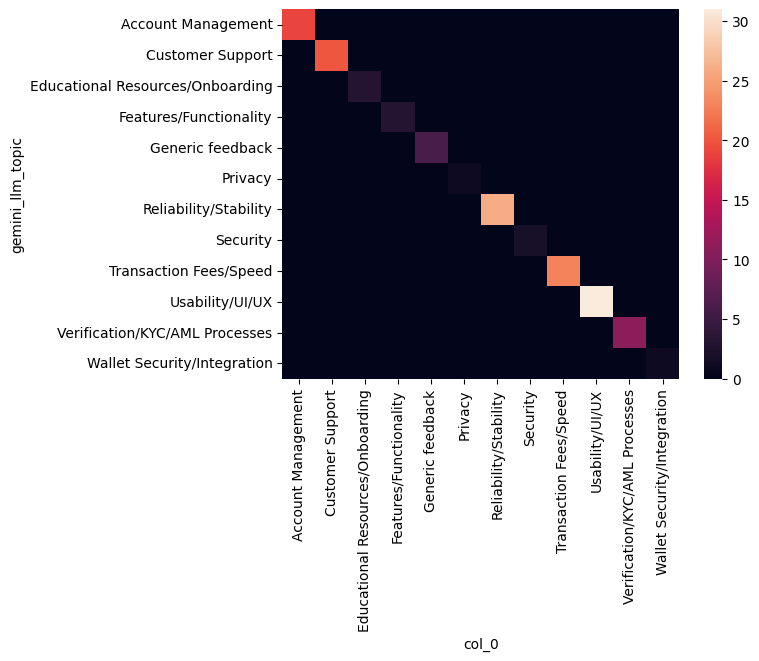

In [156]:
sns.heatmap(pd.crosstab(df_crypto.gemini_llm_topic, y_hat_cryptocom));

### Against new reviews from crypto.com

In [157]:
new_cryptocom_reviews = pd.DataFrame(get_google_play_reviews("co.mona.android", count=30))

In [158]:
y_hat_cryptocom_new = testmodel.predict(new_cryptocom_reviews.content)

Normalizing text
Tokenizing text
Passing text sequences
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [159]:
new_cryptocom_reviews["topic_mode_prediction"] = y_hat_cryptocom_new

In [160]:
from datetime import datetime

In [161]:
#new_cryptocom_reviews.to_csv("data/inference_on_unseen_cryptcom_reviews"+ datetime.today().strftime('%Y-%m-%d')+".csv",index=False)

## Errors on the Bybit reviews

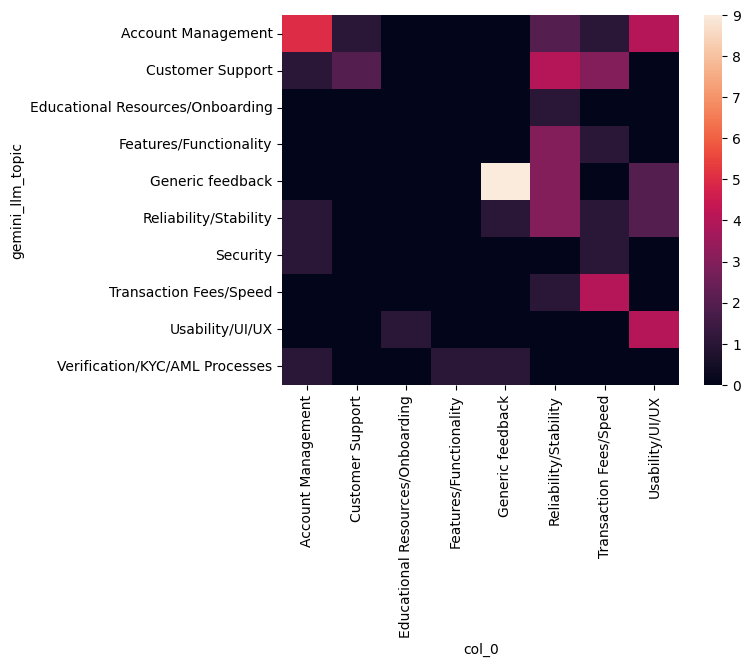

In [162]:
sns.heatmap(pd.crosstab(df_bybit.gemini_llm_topic, y_hat_bybit));

In [163]:
y_hat_bybit = testmodel.predict(df_bybit.content)
y_hat_binance = testmodel.predict(df_binance.content)

Normalizing text
Tokenizing text
Passing text sequences
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Normalizing text
Tokenizing text
Passing text sequences
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [164]:
(df_bybit.gemini_llm_topic == y_hat_bybit).mean()

0.4153846153846154

In [165]:
pd.crosstab(df_bybit.gemini_llm_topic, y_hat_bybit)

col_0,Account Management,Customer Support,Educational Resources/Onboarding,Features/Functionality,Generic feedback,Reliability/Stability,Transaction Fees/Speed,Usability/UI/UX
gemini_llm_topic,,,,,,,,
Account Management,5,1,0,0,0,2,1,4
Customer Support,1,2,0,0,0,4,3,0
Educational Resources/Onboarding,0,0,0,0,0,1,0,0
Features/Functionality,0,0,0,0,0,3,1,0
Generic feedback,0,0,0,0,9,3,0,2
Reliability/Stability,1,0,0,0,1,3,1,2
Security,1,0,0,0,0,0,1,0
Transaction Fees/Speed,0,0,0,0,0,1,4,0
Usability/UI/UX,0,0,1,0,0,0,0,4


### Errors on the Binance reviews

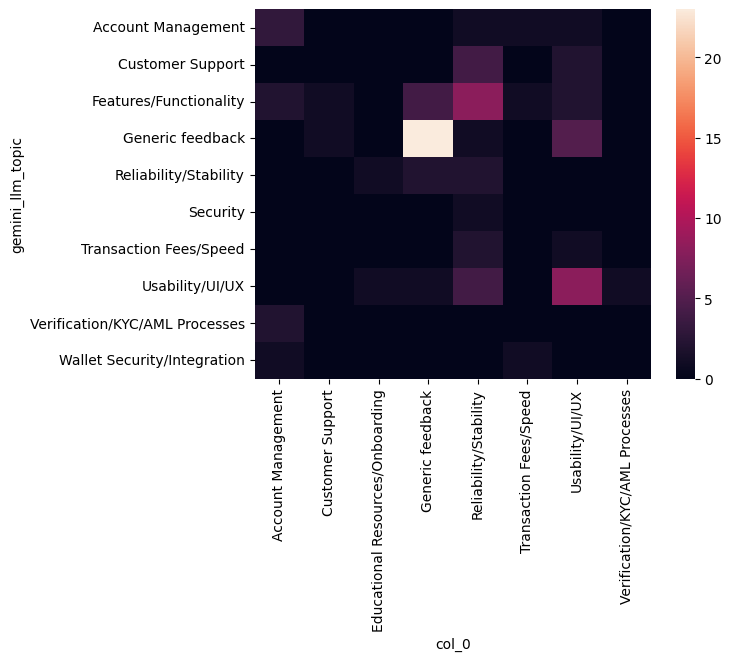

In [166]:
sns.heatmap(pd.crosstab(df_binance.gemini_llm_topic, y_hat_binance));

In [167]:
(df_binance.gemini_llm_topic == y_hat_binance).mean()

0.4090909090909091

In [168]:
pd.crosstab(df_binance.gemini_llm_topic, y_hat_binance)

col_0,Account Management,Customer Support,Educational Resources/Onboarding,Generic feedback,Reliability/Stability,Transaction Fees/Speed,Usability/UI/UX,Verification/KYC/AML Processes
gemini_llm_topic,,,,,,,,
Account Management,3,0,0,0,1,1,1,0
Customer Support,0,0,0,0,4,0,2,0
Features/Functionality,2,1,0,4,8,1,2,0
Generic feedback,0,1,0,23,1,0,5,0
Reliability/Stability,0,0,1,2,2,0,0,0
Security,0,0,0,0,1,0,0,0
Transaction Fees/Speed,0,0,0,0,2,0,1,0
Usability/UI/UX,0,0,1,1,4,0,8,1
Verification/KYC/AML Processes,2,0,0,0,0,0,0,0


In [169]:
df_binance[df_binance.content.str.lower().str.contains(" pi ")]["gemini_llm_topic"].value_counts()

gemini_llm_topic
Features/Functionality            10
Customer Support                   3
Verification/KYC/AML Processes     1
Wallet Security/Integration        1
Generic feedback                   1
Name: count, dtype: int64

In [170]:
df_binance[df_binance.content.str.lower().str.contains(" pi ")]["content"]

3      You can't call this a crypto exchange if the Exchange (binance) fails to complete KYB. This is why Pi Network is not listed. I have used binance for years, and I'm now waiting to get verified on OKx crypto exchange that has real protection because they follow protocols and procedures to create a safe environment for trading real projects and not just open source crypto scam operations that dont even have a CEO. At least I won't get scammed there.
6                                                                                                                                                                                                                                                                                                                                                                                                                      not listing of pi network and stealing my deposits
12                                                                                  

## Transfer learning with binance

Pending development.